In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
print('yep')

yep


In [3]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
data_path = os.path.join(parent_dir, 'data')
out_path = os.path.join(parent_dir, 'outputs')     # For the output

# Read the files
train = pd.read_csv(os.path.join(data_path, 'feature_engineered_data_final_v3.csv'))
labels = pd.read_csv(os.path.join(data_path, 'train_labels.csv'))


# https://www.overleaf.com/project/682deb8076098430af74efa1

In [96]:
# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
# Merge training labels
df = pd.merge(train, labels, on='id')
print('Files successfully loaded and merged!')

# Drop status_group if it already exists in train
if 'status_group' in train.columns:
    train = train.drop(columns=['status_group'])
df = train.merge(labels, on='id')
df = df.drop(columns=['region','lga', 'extraction_type', 'management']) #for now
df['water_quality_numeric'] = df['water_quality_numeric'].fillna(0)
df['water_risk_score_log'] = df['water_risk_score_log'].fillna(0)

print(df.columns)
#all categorical features (excluding target)
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_cols = [col for col in categorical_cols if col != 'status_group']

# One-hot encode medium-cardinality features (3 to 10 unique values)
onehot_cols = [col for col in categorical_cols if 2 < df[col].nunique() <= 10]
df_encoded = pd.get_dummies(df, columns=onehot_cols, drop_first=True)

# Label encode low-cardinality features (≤ 2 unique values)
label_enc_cols = [col for col in categorical_cols if df[col].nunique() <= 2]

label_encoders = {}
for col in label_enc_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df[col].astype(str)) 
    label_encoders[col] = le
    
# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(df['status_group']) 

leak_cols = [col for col in df_encoded.columns if 'status_group_' in col or 'status_group.' in col]
df_encoded = df_encoded.drop(columns=leak_cols)

# Define features and target
X = df_encoded.drop(columns=['status_group','id'])
y = y_encoded
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print(X_train.columns)

Files successfully loaded and merged!
Index(['id', 'amount_tsh', 'gps_height', 'longitude', 'latitude',
       'num_private', 'basin', 'region_code', 'district_code', 'population',
       'public_meeting', 'permit', 'construction_year', 'payment',
       'water_quality', 'quantity', 'source', 'waterpoint_type',
       'waterpoint_type_group', 'status_group_x', 'recorded_year',
       'amount_tsh_capped', 'status_group_y', 'pump_age', 'is_manual_pump',
       'water_quality_numeric', 'amount_tsh_log', 'water_risk_score_log',
       'amount_tsh_capped_log', 'population_log', 'has_private_owner',
       'pump_age_binned', 'status_group'],
      dtype='object')
Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private',
       'region_code', 'district_code', 'population', 'public_meeting',
       'permit', 'construction_year', 'recorded_year', 'amount_tsh_capped',
       'pump_age', 'is_manual_pump', 'water_quality_numeric', 'amount_tsh_log',
       'water_risk_score_log', '

Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
       'construction_year', 'extraction_type_class', 'payment',
       'water_quality', 'quantity', 'source', 'waterpoint_type'],
      dtype='object')


In [8]:
#start with origingal data 


train = pd.read_csv(os.path.join(data_path, 'train.csv'))

X = pumpit_clean(train)
le = LabelEncoder()
y = le.fit_transform(labels['status_group'])
feature_names = X.columns



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

from sklearn.ensemble import RandomForestClassifier
 

forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)
print(feature_names)

/tmp/ipykernel_13062/545661249.py:34: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[i] = df.groupby('region')[i].transform(lambda x: x.fillna(x.median))
/tmp/ipykernel_13062/545661249.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['quantity'] = df['quantity'].replace({


Index(['amount_tsh', 'gps_height', 'longitude', 'latitude', 'population',
       'construction_year', 'extraction_type_class', 'payment',
       'water_quality', 'quantity', 'source', 'waterpoint_type'],
      dtype='object')


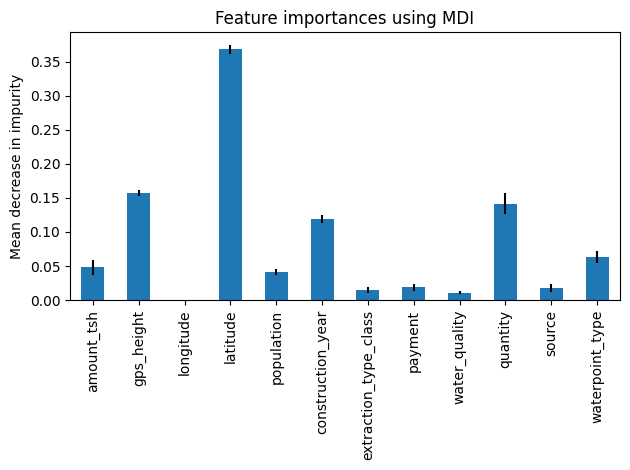

In [9]:
# pull impurity-based importance
import matplotlib.pyplot as plt


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# plot
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
plt.savefig('mdi.png')

In [10]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
) 


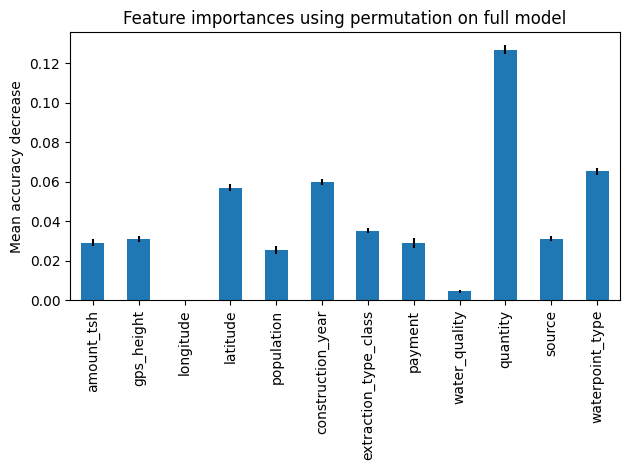

<Figure size 640x480 with 0 Axes>

In [11]:
# Importance based on feature permutation

forest_importances = pd.Series(result.importances_mean, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
plt.savefig('permutation.png')

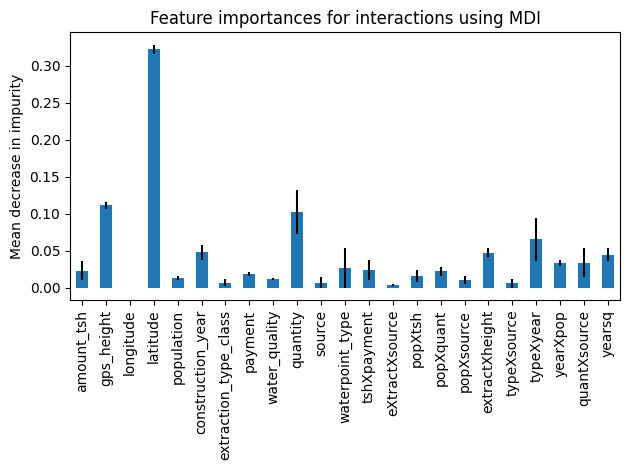

<Figure size 640x480 with 0 Axes>

In [12]:
# with interactions
X['tshXpayment'] = X.amount_tsh * X.payment
X['eXtractXsource'] = X.extraction_type_class * X.source
X['popXtsh'] = X.population * X.amount_tsh
X['popXquant'] = X.population * X.quantity
X['popXsource'] = X.population * X.source
X['extractXheight'] = X.extraction_type_class * X.gps_height
X['typeXsource'] = X.waterpoint_type * X.source
X['typeXyear'] = X.waterpoint_type * X.construction_year
X['yearXpop'] = X.construction_year * X.population
X['quantXsource'] = X.quantity * X.source
X['yearsq'] = np.sqrt(X.construction_year + 1) 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
feature_namesX = X.columns

forestX = RandomForestClassifier(random_state=42)
forestX.fit(X_train, y_train)

importancesX = forestX.feature_importances_
stdX = np.std([tree.feature_importances_ for tree in forestX.estimators_], axis=0)

# plot
forest_importancesX = pd.Series(importancesX, index=feature_namesX)

fig, ax = plt.subplots()
forest_importancesX.plot.bar(yerr=stdX, ax=ax)
ax.set_title("Feature importances for interactions using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()
plt.savefig('mdiX.png')

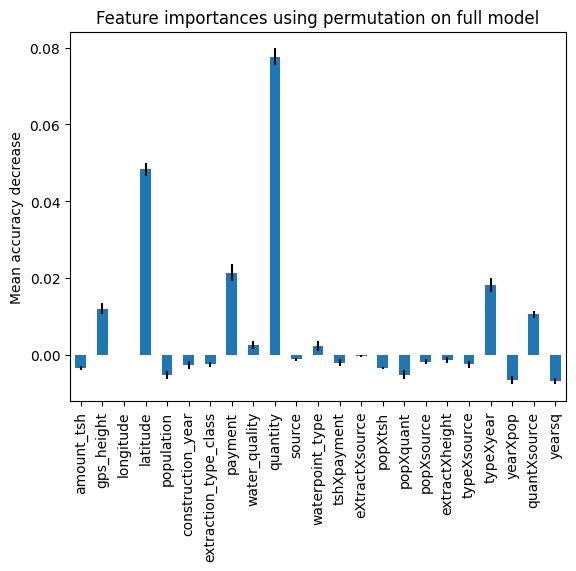

<Figure size 640x480 with 0 Axes>

In [13]:
# Importance based on feature permutation

from sklearn.inspection import permutation_importance

resultX = permutation_importance(
    forestX, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
) 



forest_importancesX = pd.Series(resultX.importances_mean, index=feature_namesX)

fig2, ax = plt.subplots()
forest_importancesX.plot.bar(yerr=resultX.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()
plt.savefig('permuteX.png')

In [114]:
forest_importancesX = pd.Series(resultX.importances_mean, index=feature_namesX)

fig, ax = plt.subplots()
forest_importancesX.plot.bar(yerr=resultX.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, X_val, y_val,

                           n_repeats=30,

                           random_state=0)


for i in r.importances_mean.argsort()[::-1]:

    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:

        print(f"{diabetes.feature_names[i]:<8}"

              f"{r.importances_mean[i]:.3f}"

              f" +/- {r.importances_std[i]:.3f}")

scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

r_multi = permutation_importance(

    model, X_val, y_val, n_repeats=30, random_state=0, scoring=scoring)


for metric in r_multi:

    print(f"{metric}")

    r = r_multi[metric]

    for i in r.importances_mean.argsort()[::-1]:

        if r.importances_mean[i] - 2 * r.importances_std[i] > 0:

            print(f"    {diabetes.feature_names[i]:<8}"

                  f"{r.importances_mean[i]:.3f}"

                  f" +/- {r.importances_std[i]:.3f}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             59400 non-null  float64
 1   gps_height             59400 non-null  float64
 2   longitude              1812 non-null   float64
 3   latitude               57588 non-null  float64
 4   population             59400 non-null  float64
 5   construction_year      59400 non-null  float64
 6   extraction_type_class  59400 non-null  int64  
 7   payment                59400 non-null  int64  
 8   water_quality          59400 non-null  int64  
 9   quantity               59400 non-null  float64
 10  source                 59400 non-null  int64  
 11  waterpoint_type        59400 non-null  int64  
dtypes: float64(7), int64(5)
memory usage: 5.4 MB


In [4]:
def pumpit_clean(df :pd.core.frame.DataFrame):
    # ``` This function requires: numpy, pandas, os,
    # ```

    # handle extra imports here
    from sklearn.preprocessing import MinMaxScaler 
    from sklearn.preprocessing import LabelEncoder

    ## Numerical Variables
    
    # amount_tsh: cap at 15000
    df['amount_tsh'] = df['amount_tsh'].apply(lambda x: min(x, 15000))
    # might want to replace this with bins
    scaler = MinMaxScaler()
    df['amount_tsh'] = scaler.fit_transform(df[['amount_tsh']]) # names kept consistent
    # gps_height 
    # # Replace invalid gps_height values (e.g. 0 or negative)
    df['gps_height'] = df['gps_height'].apply(lambda x: np.nan if x <= 0 else x) 
    # Fill using median per basin
    df['gps_height'] = df.groupby('basin')['gps_height'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fill any still missing using region median
    df['gps_height'] = df.groupby('region')['gps_height'].transform(
        lambda x: x.fillna(x.median())
    )
    df['gps_height'] = scaler.fit_transform(df[['gps_height']])

    # location:
    df['longitude'] = df['longitude'].where(df['longitude']==0, np.nan)
    df['latitude'] = df['latitude'].where(df['latitude'] < -0.5, np.nan) # too close to the equator
    for i in ['latitude','longitude']:
        df[i] = df.groupby('lga')[i].transform(lambda x: x.fillna(x.median))
        df[i] = df.groupby('region')[i].transform(lambda x: x.fillna(x.median))
        
    df.longitude = pd.to_numeric(df.longitude, errors='coerce')
    df.latitude = pd.to_numeric(df.latitude, errors='coerce')
        
    # Fill population using median by district_code
    df['population'] = df.groupby('lga')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    # Fill any still missing with median by region, then overall median
    df['population'] = df.groupby('region')['population'].transform(
        lambda x: x.fillna(x.median())
    )
    df['population'] = df['population'].fillna(df.population.median)
    # Bin the outcome, see how it behaves
    df['population'] = pd.cut(df['population'], [-1,1,25,90,160,260,9999999], labels=[0,0.1,0.2,0.4,0.6,0.9])
    df['population'] = df['population'].astype(float)
    # Construction year ??
    df['construction_year'] = df['construction_year'].replace(0, np.nan) 
    df['date_recorded'] = pd.to_datetime(df['date_recorded'])
    df['recorded_year'] = df['date_recorded'].dt.year
    #Impute using region + installer
    df['construction_year'] = df.groupby(['region', 'installer'])['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Impute using region only (for rows still missing)
    df['construction_year'] = df.groupby('region')['construction_year'].transform(
        lambda x: x.fillna(x.median())
    )
    #Use recorded year - 5
    df['construction_year'] = df['construction_year'].fillna(df['recorded_year'] - 5)
    df['construction_year'] = scaler.fit_transform(df[['construction_year']])

    ### Encode categorical variables
    
    # Encode 'quantity' (and typo fix: 'insufficent' -> 'insufficient')
    df['quantity'] = df['quantity'].replace({
        'enough': 1,
        'seasonal': 0.6,
        'insufficient': 0.4,
        'dry': 0,
        'unknown': 0
    })
    df.quantity = pd.to_numeric(df.quantity, errors='coerce')
    
    # Encode 'water_quality' as binary: good = 1, else 0
    df['water_quality'] = np.where(df['water_quality'] == 'soft', 1, 0)
    # Encode 'waterpoint_type' (1 = preferred type, 0 = everything else)
    preferred_waterpoint = ['hand pump', 'communal standpipe']
    df['waterpoint_type'] = df['waterpoint_type'].apply(lambda x: 1 if x in preferred_waterpoint else 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['payment'] = np.where(df['payment'] == 'never pay', 0, 1) 
    # Encode 'source' (1 = preferred sources, 0 = everything else)
    preferred_sources = ['spring', 'river', 'rainwater harvesting']
    df['source'] = df['source'].apply(lambda x: 1 if x in preferred_sources else 0)
    # Encode 'payment' as binary: never pay = 0, else = 1
    df['extraction_type_class'] = np.where(df['extraction_type_class'] == 'gravity', 0, 1)
    
    #  Drop other columns and only keep these:
    df = df[['amount_tsh',
             'gps_height',
             'longitude',
             'latitude',
             'population',
             'construction_year',
             'extraction_type_class',
             'payment',
            'water_quality',
            'quantity',
            'source',
            'waterpoint_type',
       ]] 
    
    return df 
